 **Nidhi Rajkumar Saini**<br>
 **USCID: 3730422872**

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import operator
from tabulate import tabulate
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
TrainingErrors = {}
compareMetrics = []
compareWeightedMetrics = []

In [3]:
# Function to use Dataframe.apply for label encoding class AB = 1 and NO = 0
def func(x):
    if x.decode()=="Abnormal":
        return 1
    else:
        return 0

In [4]:
# Split dataset into training data and testing data
def TrainTestSplit(dataX, dataY, NOlimit, ABlimit):
    Xtrain = []
    Ytrain = []
    Xtest = []
    Ytest = []
    NOCnt = 0
    ABCnt = 0
    for i in range(0, len(dataY)):
        if dataY[i]==0:
            # first NOlimit rows of Class 0 in training set 
            if NOCnt<NOlimit:
                Xtrain.append(dataX[i])
                Ytrain.append(dataY[i])
                NOCnt += 1
            else:
                Xtest.append(dataX[i])
                Ytest.append(dataY[i])
        else:
            # first ABlimit rows of Class 1 in training set
            if ABCnt<ABlimit:
                Xtrain.append(dataX[i])
                Ytrain.append(dataY[i])
                ABCnt += 1
            else:
                Xtest.append(dataX[i])
                Ytest.append(dataY[i])
    Xtrain = np.asarray(Xtrain)
    Ytrain = np.asarray(Ytrain)
    Xtest = np.asarray(Xtest)
    Ytest = np.asarray(Ytest)
    return Xtrain, Ytrain, Xtest, Ytest

In [5]:
# Plot train and test error for different values of K
def plotTrainTestError(trainErrorDict, testErrorDict, metric, trainLabel, testLabel, KStart, KEnd):
    # plot K vs training error 
    plt.plot(trainErrorDict.keys(), trainErrorDict.values(), 'green', label = trainLabel)
    # plot K vs testing error
    plt.plot(testErrorDict.keys(), testErrorDict.values(), 'magenta', label = testLabel)
    plt.title('Error vs Value of K using ' + metric + ' distance metric', style = 'oblique')
    plt.xlim(KStart, KEnd)
    plt.ylabel('Error Rate')
    plt.xlabel('Value of K')
    plt.legend()
    plt.show()

In [6]:
# Plot learning curve
def plotLearningCurve(errorDict, metric):
    plt.plot(errorDict.keys(), errorDict.values(), 'purple')
    plt.title('Learning curve using ' + metric + ' distance metric')
    plt.ylabel('Error Rate')
    plt.xlabel('Training Set Size')
    plt.show()

In [7]:
def KNNClassifier(X_train, Y_train, X_test, Y_test, KStart, KEnd, KDiff, KNN_weight, KNN_metric, KNN_p):
    train_errorDict = {}
    test_errorDict = {}
    confusionMatrixDict = {}
    
    for i in range(KStart,KEnd,KDiff):
        if(KNN_metric == 'minkowski'):
            KNN = KNeighborsClassifier(n_neighbors = i, metric = 'minkowski', weights = KNN_weight, p = KNN_p)
        elif(KNN_metric == 'mahalanobis'):
            KNN = KNeighborsClassifier(n_neighbors = i, algorithm = 'brute', metric = KNN_metric,
                                       metric_params = {'V': np.cov(X_train,rowvar=False)}, weights = KNN_weight)
        else:
            KNN = KNeighborsClassifier(n_neighbors = i, metric = KNN_metric, weights = KNN_weight)
        KNN.fit(X_train,Y_train)
        # get predictions on fitted KNN model for test data
        predictedY = KNN.predict(X_test)
        # compute prediction error on train data
        accuracy = KNN.score(X_train, Y_train)
        error = 1-round(accuracy, 3)
        train_errorDict[i] = error
        # compute prediction error on test data
        accuracy = KNN.score(X_test, Y_test)
        error = 1-round(accuracy, 3)
        test_errorDict[i] = error
        # compute confusion matrix of test data
        confusionMatrix = confusion_matrix(Y_test, predictedY, labels = [1, 0])
        confusionMatrixDict[i] = confusionMatrix
        
    # collecting all training errors in a dictionary
    for key, value in train_errorDict.items():
        idx = "K=" + str(key) + " Metric:" + KNN_metric.strip() + ' Polling:' + KNN_weight.strip()
        TrainingErrors[idx] = value
        
    return train_errorDict, test_errorDict, confusionMatrixDict

In [8]:
# Compute model measures: Confusion matrix, True positive rate, True negative rate, Precision, and F1-score
def computeMeasures(errorDict, confusionMatrixDict, check_k):
    measures = []
    # sort error dictionary to get min error
    errorDict_sorted = sorted(errorDict.items(), key=operator.itemgetter(1))
    # get value of K with min error (K*)
    Kstar = errorDict_sorted[0][0]
    minError = errorDict_sorted[0][1]
    # avoid K = 1 when desired as it can often cause overfitting
    if(check_k == True & Kstar == 1):
        Kstar = errorDict_sorted[1][0]
        minError = errorDict_sorted[1][1]
    # get confusion matrix of K*
    confusionMatrix = confusionMatrixDict[Kstar]
    # get True Positive, True Negative, False Positive and False Negative
    truePositive = confusionMatrix[0][0]
    falseNegative = confusionMatrix[0][1]
    falsePositive = confusionMatrix[1][0]
    trueNegative = confusionMatrix[1][1] 
    # compute True Positive Rate, True Negative Rate, Precision and F1-Score
    truePositiveRate = round(truePositive / (truePositive + falseNegative), 2)
    trueNegativeRate = round(trueNegative / (trueNegative + falsePositive), 2)
    precision = round(truePositive / (truePositive + falsePositive), 2)
    F1Score = round(2 * precision * truePositiveRate / (precision + truePositiveRate), 2)
    measures.append(Kstar)
    measures.append(confusionMatrix)
    measures.append(truePositiveRate)
    measures.append(trueNegativeRate)
    measures.append(precision)
    measures.append(F1Score)
    return minError, measures

# **Loading the Vertebral Column dataset**

In [9]:
data = arff.loadarff('../data/vertebral_column_data/column_2C_weka.arff')
df = pd.DataFrame(data[0])
df

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,b'Abnormal'
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,b'Abnormal'
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,b'Abnormal'
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,b'Abnormal'
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,b'Abnormal'
...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,b'Normal'
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,b'Normal'
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,b'Normal'
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,b'Normal'


# **Pre-Processing and Exploratory data analysis**

## Label encode class to 0 and 1 (NO = 0 and AB = 1) 

In [10]:
df['class'] = (df.apply(lambda x: func(x['class']), axis=1))
df

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,1
...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,0
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,0
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,0
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,0


## Group features and label to separate dataframes

In [11]:
# Put all Features to dataX dataframe
dataX = df[df.columns[:-1]].copy()
dataX

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501
...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750


In [12]:
# Put Label column to dataY dataframe
dataY = df['class'].copy()
dataY

0      1
1      1
2      1
3      1
4      1
      ..
305    0
306    0
307    0
308    0
309    0
Name: class, Length: 310, dtype: int64

In [13]:
arrdataX = np.array(dataX) #convert dataX to numpy ndarray
print("dataX:\n",arrdataX)
print("dataY:\n",dataY)

dataX:
 [[ 63.0278175   22.55258597  39.60911701  40.47523153  98.67291675
   -0.25439999]
 [ 39.05695098  10.06099147  25.01537822  28.99595951 114.4054254
    4.56425864]
 [ 68.83202098  22.21848205  50.09219357  46.61353893 105.9851355
   -3.53031731]
 ...
 [ 61.44659663  22.6949683   46.17034732  38.75162833 125.6707246
   -2.70787952]
 [ 45.25279209   8.69315736  41.5831264   36.55963472 118.5458418
    0.21475017]
 [ 33.84164075   5.07399141  36.64123294  28.76764934 123.9452436
   -0.19924909]]
dataY:
 0      1
1      1
2      1
3      1
4      1
      ..
305    0
306    0
307    0
308    0
309    0
Name: class, Length: 310, dtype: int64


## Scatterplots of the independent variables in the dataset

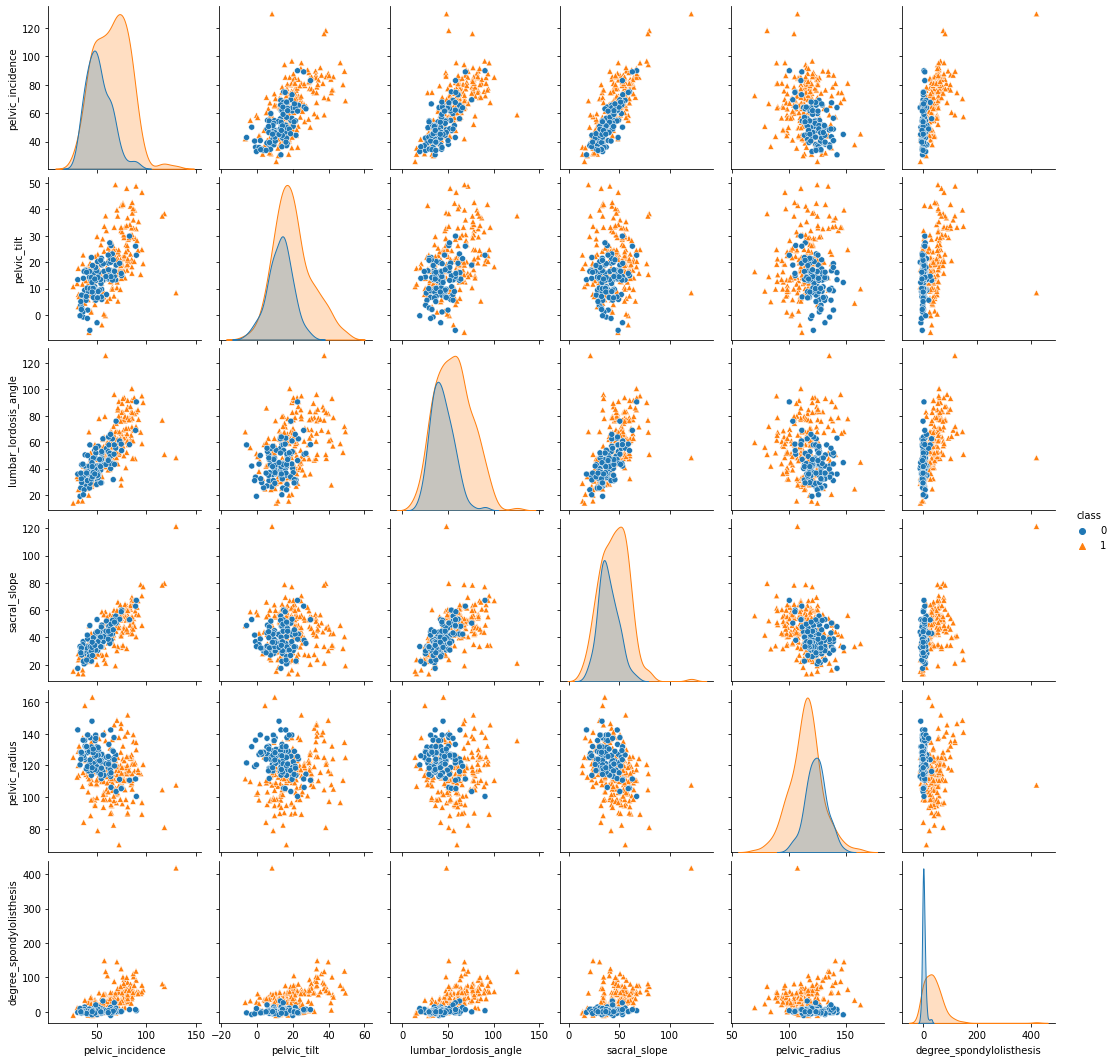

In [14]:
# Class 0: Normal, Class 1: Abnormal
sns.pairplot(df, kind='scatter', hue ='class',markers=["o", "^"])

## Boxplots for each of the independent variables

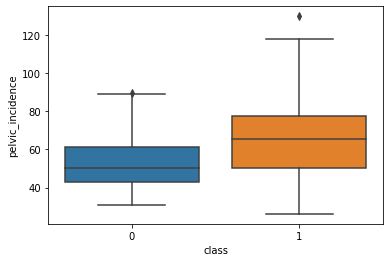

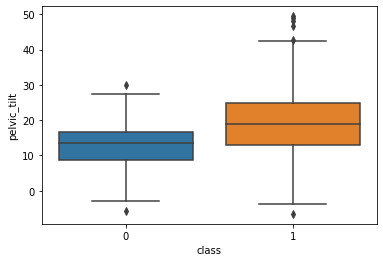

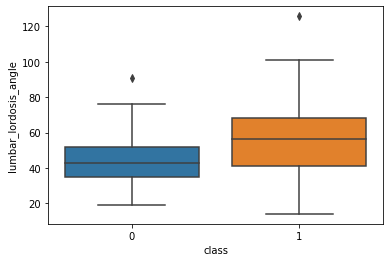

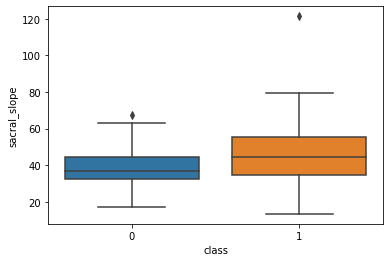

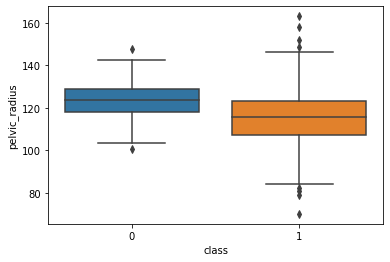

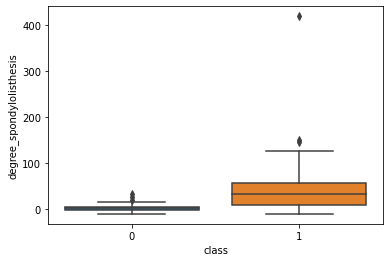

In [15]:
# Class 0: Normal, Class 1: Abnormal
classlabel = df['class']
for i in range(0,len(dataX.columns)):
    feature = df[dataX.columns[i]]
    sns.boxplot(x = classlabel, y = feature)
    plt.show()

## Split the data into Training set and Testing set

In [16]:
# Select the first 70 rows of Class 0 and the first 140 rows of Class 1 as the training set and the rest of the data as the test set.
Xtrain, Ytrain, Xtest, Ytest = TrainTestSplit(arrdataX, dataY, 70, 140)

# **Classification using KNN on Vertebral Column Data Set**

## KNN Classification using Euclidean Distance Metric and Majority Polling

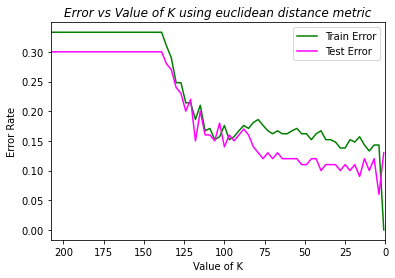

+------+--------------------+--------------------+----------------------+----------------------+-------------+------------+
|   K* |   Least Test Error | Confusion Matrix   |   True Positive Rate |   True Negative Rate |   Precision |   F1-Score |
+======+====================+====================+======================+======================+=============+============+
|    4 |               0.06 | [[69  1]           |                 0.99 |                 0.83 |        0.93 |       0.96 |
|      |                    |  [ 5 25]]          |                      |                      |             |            |
+------+--------------------+--------------------+----------------------+----------------------+-------------+------------+


In [17]:
# KNN - Euclidean and majority polling
start_k = 208
end_k = 0
diff_k = -3
metric = 'euclidean'
weight = 'uniform'
p = 2
check_k = False

trainError, testError, testconfusionMatrix = KNNClassifier(Xtrain, Ytrain, Xtest, Ytest, start_k, end_k, diff_k, weight, metric, p)
plotTrainTestError(trainError, testError, metric, 'Train Error', 'Test Error', start_k, end_k)
leastError, measures = computeMeasures(testError, testconfusionMatrix, check_k)

tableHeaders = ["K*", "Least Test Error", "Confusion Matrix", "True Positive Rate", "True Negative Rate","Precision","F1-Score"]
tableData = []
measures.insert(1, leastError)
tableData.append(measures)
print(tabulate(tableData, tableHeaders, tablefmt="grid"))

## Learning Curve: Find best K and plot best Test error rate against varying size of Training set

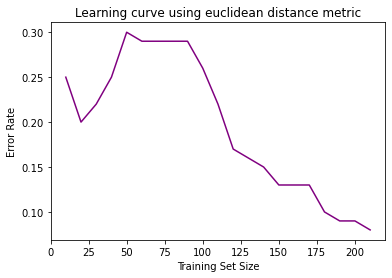

+--------------+------+--------------------+--------------------+-------+-------+-------------+------------+
|   Train Size |   K* |   Least Test Error | Confusion Matrix   |   TPR |   TNR |   Precision |   F1-score |
+==============+======+====================+====================+=======+=======+=============+============+
|           10 |    1 |               0.25 | [[65  5]           |  0.93 |  0.33 |        0.76 |       0.84 |
|              |      |                    |  [20 10]]          |       |       |             |            |
+--------------+------+--------------------+--------------------+-------+-------+-------------+------------+
|           20 |    6 |               0.2  | [[66  4]           |  0.94 |  0.47 |        0.8  |       0.86 |
|              |      |                    |  [16 14]]          |       |       |             |            |
+--------------+------+--------------------+--------------------+-------+-------+-------------+------------+
|           30 |   

In [18]:
# Plot best test error rate varying the size of training data (floor(N/3): Class 0 and N-floor(N/3): Class 1)
tableData = []
errorDict = {}
weight = 'uniform'
metric = 'euclidean'
p = 2
check_k = False

for N in range(10,211,10):
    NOcnt = math.floor(N/3)
    ABcnt = N-math.floor(N/3)    
    XtrainNew, YtrainNew, _, _1 = TrainTestSplit(Xtrain, Ytrain, NOcnt, ABcnt)
    trainError, testError, testconfusionMatrix = KNNClassifier(XtrainNew, YtrainNew, Xtest, Ytest, 1, N, 5, weight, metric, p)
    leastError, measures = computeMeasures(testError, testconfusionMatrix, check_k)
    measures.insert(0, N)
    measures.insert(2, leastError)
    tableData.append(measures)
    errorDict[N] = leastError

plotLearningCurve(errorDict, metric)
tableHeaders = ["Train Size", "K*", "Least Test Error", "Confusion Matrix", "TPR", "TNR","Precision","F1-score"]
print(tabulate(tableData, tableHeaders, tablefmt="grid"))

## KNN Classification with Manhattan Distance Metric and Majority Polling

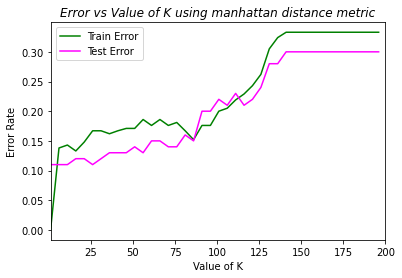

+-----------+------+--------------------+--------------------+-------+-------+-------------+------------+
| Metric    |   K* |   Least Test Error | Confusion Matrix   |   TPR |   TNR |   Precision |   F1-Score |
+===========+======+====================+====================+=======+=======+=============+============+
| Manhattan |    6 |               0.11 | [[67  3]           |  0.96 |  0.73 |        0.89 |       0.92 |
|           |      |                    |  [ 8 22]]          |       |       |             |            |
+-----------+------+--------------------+--------------------+-------+-------+-------------+------------+


In [19]:
# KNN using Manhattan distance metric and majority polling
start_k = 1
end_k = 200
diff_k = 5
metric = 'manhattan'
weight = 'uniform'
p = 1
check_k = True

trainError, testError, testconfusionMatrix = KNNClassifier(Xtrain, Ytrain, Xtest, Ytest, start_k, end_k, diff_k, weight, metric, p)
plotTrainTestError(trainError, testError, metric, 'Train Error', 'Test Error', start_k, end_k)
leastError, manhattanMeasures = computeMeasures(testError, testconfusionMatrix, check_k)

manhattanMeasures.insert(0, 'Manhattan')
manhattanMeasures.insert(2, leastError)
tableHeaders = ["Metric", "K*", "Least Test Error", "Confusion Matrix", "TPR", "TNR", "Precision", "F1-Score"]
tableData = []
tableData.append(manhattanMeasures)
print(tabulate(tableData, tableHeaders, tablefmt="grid"))
compareMetrics.append(manhattanMeasures)

## KNN Classification with Minkowski Distance Metric and Majority Polling

In [20]:
# KNN using Minkowski distance metric with different logP values and K* of Manhattan distance K classifier
logPStart = 0.1
logPIncrement = 0.1
test_errorDict = {}
kstar = manhattanMeasures[1]
KNN_metric = 'minkowski'
KNN_weight = 'uniform'    

while logPStart<=1.0:
    KNN_p = round(math.pow(10, logPStart))
    KNN = KNeighborsClassifier(n_neighbors = kstar, metric = KNN_metric, p = KNN_p, weights = KNN_weight)
    KNN.fit(Xtrain,Ytrain)
    predictedY = KNN.predict(Xtest)
    # compute prediction error on test data
    accuracy = KNN.score(Xtest, Ytest)
    error = 1-round(accuracy, 3)
    test_errorDict[logPStart] = error
    logPStart = ((logPStart*10) + (logPIncrement*10))/10

tableHeaders = ["logP", "Least Test Error"]
tableData = []
for key, value in test_errorDict.items():
    tableData.append([key, value])
print('Test Error for different values of logP')
print(tabulate(tableData, tableHeaders, tablefmt="grid"))
sortedError = sorted(test_errorDict.items(), key=operator.itemgetter(1))
print('Best logP value:', sortedError[0][0], 'with Test error:', round(sortedError[0][1], 2))   

Test Error for different values of logP
+--------+--------------------+
|   logP |   Least Test Error |
+========+====================+
|    0.1 |               0.11 |
+--------+--------------------+
|    0.2 |               0.08 |
+--------+--------------------+
|    0.3 |               0.08 |
+--------+--------------------+
|    0.4 |               0.08 |
+--------+--------------------+
|    0.5 |               0.08 |
+--------+--------------------+
|    0.6 |               0.06 |
+--------+--------------------+
|    0.7 |               0.07 |
+--------+--------------------+
|    0.8 |               0.08 |
+--------+--------------------+
|    0.9 |               0.09 |
+--------+--------------------+
|    1   |               0.09 |
+--------+--------------------+
Best logP value: 0.6 with Test error: 0.06


## KNN Classification with Chebyshev Distance Metric and Majority Polling

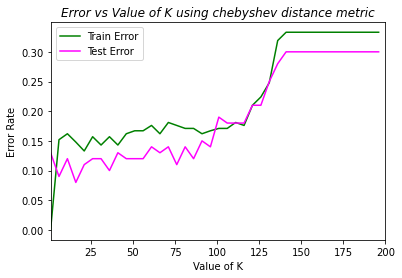

+-----------+------+--------------------+--------------------+-------+-------+-------------+------------+
| Metric    |   K* |   Least Test Error | Confusion Matrix   |   TPR |   TNR |   Precision |   F1-Score |
+===========+======+====================+====================+=======+=======+=============+============+
| Chebyshev |   16 |               0.08 | [[70  0]           |     1 |  0.73 |         0.9 |       0.95 |
|           |      |                    |  [ 8 22]]          |       |       |             |            |
+-----------+------+--------------------+--------------------+-------+-------+-------------+------------+


In [21]:
# KNN using Chebyshev distance metric
start_k = 1
end_k = 200
diff_k = 5
metric = 'chebyshev'
weight = 'uniform'
check_k = False

trainError, testError, testconfusionMatrix = KNNClassifier(Xtrain, Ytrain, Xtest, Ytest, start_k, end_k, diff_k, weight, metric, p)
plotTrainTestError(trainError, testError, metric, 'Train Error', 'Test Error', start_k, end_k)
leastError, chebyshevMeasures = computeMeasures(testError, testconfusionMatrix, check_k)

chebyshevMeasures.insert(0, 'Chebyshev')
chebyshevMeasures.insert(2, leastError)
tableHeaders = ["Metric", "K*", "Least Test Error", "Confusion Matrix", "TPR", "TNR", "Precision", "F1-Score"]
tableData = []
tableData.append(chebyshevMeasures)
print(tabulate(tableData, tableHeaders, tablefmt="grid"))
compareMetrics.append(chebyshevMeasures)

## KNN Classification with Mahalanobis Distance Metric and Majority Polling

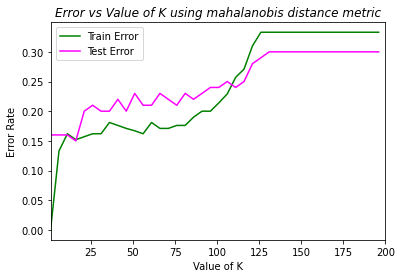

+-------------+------+--------------------+--------------------+-------+-------+-------------+------------+
| Metric      |   K* |   Least Test Error | Confusion Matrix   |   TPR |   TNR |   Precision |   F1-Score |
+=============+======+====================+====================+=======+=======+=============+============+
| Mahalanobis |   16 |               0.15 | [[66  4]           |  0.94 |  0.63 |        0.86 |        0.9 |
|             |      |                    |  [11 19]]          |       |       |             |            |
+-------------+------+--------------------+--------------------+-------+-------+-------------+------------+


In [22]:
# KNN Classification with Mahalanobis Distance Metric and Majority Polling
start_k = 1
end_k = 200
diff_k = 5
metric = 'mahalanobis'
weight = 'uniform'
p=0
check_k = False

trainError, testError, testconfusionMatrix = KNNClassifier(Xtrain, Ytrain, Xtest, Ytest, start_k, end_k, diff_k, weight, metric, p)
plotTrainTestError(trainError, testError, metric, 'Train Error', 'Test Error', start_k, end_k)
leastError, mahalanobisMeasures = computeMeasures(testError, testconfusionMatrix, check_k)

mahalanobisMeasures.insert(0, 'Mahalanobis')
mahalanobisMeasures.insert(2, leastError)
tableHeaders = ["Metric", "K*", "Least Test Error", "Confusion Matrix", "TPR", "TNR", "Precision", "F1-Score"]
tableData = []
tableData.append(mahalanobisMeasures)
print(tabulate(tableData, tableHeaders, tablefmt="grid"))
compareMetrics.append(mahalanobisMeasures)

## Comparison between different Distance Metrics using KNN with Majority Polling

In [23]:
# Comparison of KNN metrics using majority polling
tableHeaders = ["Distance Metric", "Best K", "Least Test Error", "Confusion Matrix", "TPR", "TNR","Precision", "F1-Score"]
print(tabulate(compareMetrics, tableHeaders, tablefmt="grid"))

+-------------------+----------+--------------------+--------------------+-------+-------+-------------+------------+
| Distance Metric   |   Best K |   Least Test Error | Confusion Matrix   |   TPR |   TNR |   Precision |   F1-Score |
+===================+==========+====================+====================+=======+=======+=============+============+
| Manhattan         |        6 |               0.11 | [[67  3]           |  0.96 |  0.73 |        0.89 |       0.92 |
|                   |          |                    |  [ 8 22]]          |       |       |             |            |
+-------------------+----------+--------------------+--------------------+-------+-------+-------------+------------+
| Chebyshev         |       16 |               0.08 | [[70  0]           |  1    |  0.73 |        0.9  |       0.95 |
|                   |          |                    |  [ 8 22]]          |       |       |             |            |
+-------------------+----------+--------------------+---

## KNN Classification with Euclidean Distance Metric and Weighted Polling

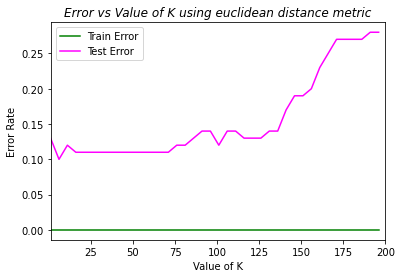

+-----------+------+--------------------+--------------------+-------+-------+-------------+------------+
| Metric    |   K* |   Least Test Error | Confusion Matrix   |   TPR |   TNR |   Precision |   F1-Score |
+===========+======+====================+====================+=======+=======+=============+============+
| Euclidean |    6 |                0.1 | [[70  0]           |     1 |  0.67 |        0.88 |       0.94 |
|           |      |                    |  [10 20]]          |       |       |             |            |
+-----------+------+--------------------+--------------------+-------+-------+-------------+------------+


In [24]:
# KNN - Euclidean, Weighted polling
start_k = 1
end_k = 200
diff_k = 5
metric = 'euclidean'
weight = 'distance'
p = 2
check_k = False
trainError, testError, testconfusionMatrix = KNNClassifier(Xtrain, Ytrain, Xtest, Ytest, start_k, end_k, diff_k, weight, metric, p)
plotTrainTestError(trainError, testError, metric, 'Train Error', 'Test Error', start_k, end_k)
leastError, euclideanMeasures = computeMeasures(testError, testconfusionMatrix, check_k)

euclideanMeasures.insert(0, 'Euclidean')
euclideanMeasures.insert(2, leastError)
tableHeaders = ["Metric", "K*", "Least Test Error", "Confusion Matrix", "TPR", "TNR", "Precision", "F1-Score"]
tableData = []
tableData.append(euclideanMeasures)
print(tabulate(tableData, tableHeaders, tablefmt="grid"))
compareWeightedMetrics.append(euclideanMeasures)

## KNN Classification with Manhattan Distance Metric and Weighted Polling

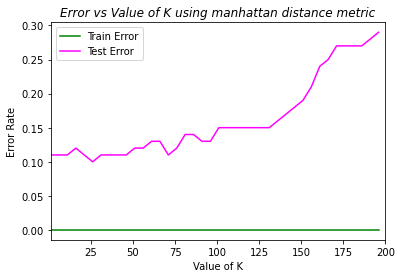

+-----------+------+--------------------+--------------------+-------+-------+-------------+------------+
| Metric    |   K* |   Least Test Error | Confusion Matrix   |   TPR |   TNR |   Precision |   F1-Score |
+===========+======+====================+====================+=======+=======+=============+============+
| Manhattan |   26 |                0.1 | [[69  1]           |  0.99 |   0.7 |        0.88 |       0.93 |
|           |      |                    |  [ 9 21]]          |       |       |             |            |
+-----------+------+--------------------+--------------------+-------+-------+-------------+------------+


In [25]:
# KNN using Manhattan distance metric and weighted polling
start_k = 1
end_k = 200
diff_k = 5
metric = 'manhattan'
weight = 'distance'
p = 1
check_k = False

trainError, testError, testconfusionMatrix = KNNClassifier(Xtrain, Ytrain, Xtest, Ytest, start_k, end_k, diff_k, weight, metric, p)
plotTrainTestError(trainError, testError, metric, 'Train Error', 'Test Error', start_k, end_k)
leastError, manhattanMeasures = computeMeasures(testError, testconfusionMatrix, check_k)

manhattanMeasures.insert(0, 'Manhattan')
manhattanMeasures.insert(2, leastError)
tableHeaders = ["Metric", "K*", "Least Test Error", "Confusion Matrix", "TPR", "TNR", "Precision", "F1-Score"]
tableData = []
tableData.append(manhattanMeasures)
print(tabulate(tableData, tableHeaders, tablefmt="grid"))
compareWeightedMetrics.append(manhattanMeasures)

## KNN Classification with Chebyshev Distance Metric and Weighted Polling

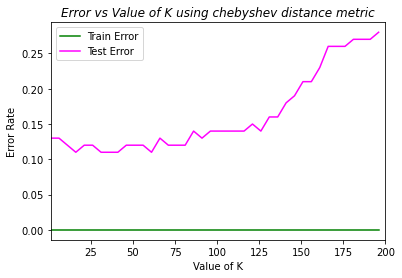

+-----------+------+--------------------+--------------------+-------+-------+-------------+------------+
| Metric    |   K* |   Least Test Error | Confusion Matrix   |   TPR |   TNR |   Precision |   F1-Score |
+===========+======+====================+====================+=======+=======+=============+============+
| Chebyshev |   16 |               0.11 | [[70  0]           |     1 |  0.63 |        0.86 |       0.92 |
|           |      |                    |  [11 19]]          |       |       |             |            |
+-----------+------+--------------------+--------------------+-------+-------+-------------+------------+


In [26]:
# KNN using Chebyshev distance metric and Weighted polling
start_k = 1
end_k = 200
diff_k = 5
metric = 'chebyshev'
weight = 'distance'
check_k = False

trainError, testError, testconfusionMatrix = KNNClassifier(Xtrain, Ytrain, Xtest, Ytest, start_k, end_k, diff_k, weight, metric, p)
plotTrainTestError(trainError, testError, metric, 'Train Error', 'Test Error', start_k, end_k)
leastError, chebyshevMeasures = computeMeasures(testError, testconfusionMatrix, check_k)

chebyshevMeasures.insert(0, 'Chebyshev')
chebyshevMeasures.insert(2, leastError)
tableHeaders = ["Metric", "K*", "Least Test Error", "Confusion Matrix", "TPR", "TNR", "Precision", "F1-Score"]
tableData = []
tableData.append(chebyshevMeasures)
print(tabulate(tableData, tableHeaders, tablefmt="grid"))
compareWeightedMetrics.append(chebyshevMeasures)

## Comparison between different Distance Metrics using KNN with Weighted Polling

In [27]:
tableHeaders = ["Distance Metric", "Best K", "Least Test Error", "Confusion Matrix", "TPR", "TNR","Precision","F1-Score"]
print(tabulate(compareWeightedMetrics, tableHeaders, tablefmt="grid"))

+-------------------+----------+--------------------+--------------------+-------+-------+-------------+------------+
| Distance Metric   |   Best K |   Least Test Error | Confusion Matrix   |   TPR |   TNR |   Precision |   F1-Score |
+===================+==========+====================+====================+=======+=======+=============+============+
| Euclidean         |        6 |               0.1  | [[70  0]           |  1    |  0.67 |        0.88 |       0.94 |
|                   |          |                    |  [10 20]]          |       |       |             |            |
+-------------------+----------+--------------------+--------------------+-------+-------+-------------+------------+
| Manhattan         |       26 |               0.1  | [[69  1]           |  0.99 |  0.7  |        0.88 |       0.93 |
|                   |          |                    |  [ 9 21]]          |       |       |             |            |
+-------------------+----------+--------------------+---

## Lowest Training Error in KNN Classification

In [28]:
# Lowest training error
sortedTrainingErrors = sorted(TrainingErrors.items(), key=operator.itemgetter(1))
print('Lowest training error achieved in this homework is', sortedTrainingErrors[0][1],"when", sortedTrainingErrors[0][0])
if (sortedTrainingErrors[0][1] == 0):
    print("When K = 1, we are selecting the closest training sample to our test sample. Since our test sample is in the training dataset, it will choose itself as the closest and never make mistake. Hence, the training error will be zero when K = 1, irrespective of the distance metric used.")

Lowest training error achieved in this homework is 0.0 when K=1 Metric:euclidean Polling:uniform
When K = 1, we are selecting the closest training sample to our test sample. Since our test sample is in the training dataset, it will choose itself as the closest and never make mistake. Hence, the training error will be zero when K = 1, irrespective of the distance metric used.


# **References**

In [29]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# https://stackoverflow.com/questions/40506390/pandas-series-object-has-no-attribute-colnames-when-using-apply
# https://www.datacamp.com/community/tutorials/pandas-apply
# https://www.programmersought.com/article/46886577631/
# https://www.machinelearningplus.com/statistics/mahalanobis-distance/
# https://datatofish.com/covariance-matrix-python/
# https://numpy.org/doc/stable/reference/generated/numpy.cov.html